# Imbalance problem
- Most machine learning algorithms assume data equally distributed. So when we have a class imbalance, the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class.

## SMOTE (Synthetic Minority Oversampling TEchnique)
- a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). 
- A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.
- SMOTE + RandomUnderSampler is fine


In [1]:
import warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [3]:
import imblearn

In [4]:
print(imblearn.__version__)

0.10.0


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [7]:
# define dataset
from sklearn.datasets import make_classification
X_org, y_org = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	                       n_clusters_per_class=1, weights=[0.99], flip_y=0, 
                           random_state=1)

In [8]:
X_org.shape, y_org.shape

((10000, 2), (10000,))

In [9]:
len(y_org[y_org==0]), len(y_org[y_org==1])

(9900, 100)

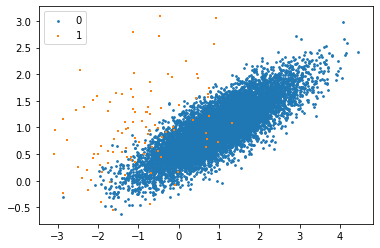

In [10]:
markers = ['o', '+']
for i in range(2):
    xs = X_org[:, 0][y_org == i]
    ys = X_org[:, 1][y_org == i]
    plt.scatter(xs, ys, marker=markers[i], label=str(i), s=3)
plt.legend()
plt.show()

In [11]:
def print_result(X_train, X_test, y_train, y_test):

    model = RandomForestClassifier(n_estimators=100, max_depth=5)
    print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Static performance: ", "\n", confusion_matrix(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))

    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    print("AUC score: ", auc(fpr, tpr))

In [12]:
# classification on original dataset
X, y = X_org.copy(), y_org.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print("original distribution: ", len(y[y==0])/len(y), len(y[y==1])/len(y))
print("Train data distribution: ", len(y_train[y_train==0])/len(y_train), len(y_train[y_train==1])/len(y_train))
print("Test data distribution: ", len(y_test[y_test==0])/len(y_test), len(y_test[y_test==1])/len(y_test))

print_result(X_train, X_test, y_train, y_test)

original distribution:  0.99 0.01
Train data distribution:  0.99 0.01
Test data distribution:  0.99 0.01
Shapes:  (7000, 2) (3000, 2) (7000,) (3000,)
Static performance:  
 [[2968    2]
 [  17   13]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2970
           1       0.87      0.43      0.58        30

    accuracy                           0.99      3000
   macro avg       0.93      0.72      0.79      3000
weighted avg       0.99      0.99      0.99      3000

AUC score:  0.9551851851851851


- look at Bad Recall score.
  - Because of imbalance. (Think of it as detecting threatening objects such as guns and knives.

In [20]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X_org, y_org)
sc = StandardScaler()
X_sc=sc.fit_transform(X)

In [23]:
X_sc.shape, y.shape , len(y[y==0]), len(y[y==1])

((19800, 2), (19800,), 9900, 9900)

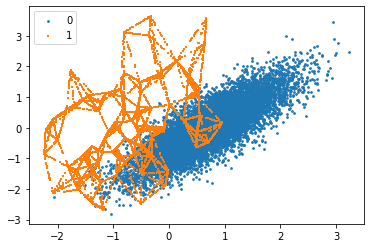

In [24]:
markers = ['o', '+']
for i in range(2):
    xs = X_sc[:, 0][y == i]
    ys = X_sc[:, 1][y == i]
    plt.scatter(xs, ys, marker=markers[i], label=str(i), s=3)
plt.legend()
plt.show()

In [27]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler()
X, y = under.fit_resample(X_org, y_org)
X_sc=sc.fit_transform(X)
print(len(y[y==0]), len(y[y==1]))

100 100


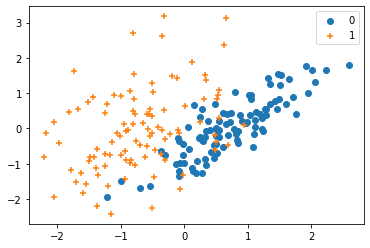

In [28]:
markers = ['o', '+']
for i in range(2):
    xs = X_sc[:, 0][y == i]
    ys = X_sc[:, 1][y == i]
    plt.scatter(xs, ys, marker=markers[i], label=str(i))
plt.legend()
plt.show()

## Original paper on SMOTE
- combine SMOTE and Undersampler()

- The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.
- We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1,000), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2,000).

In [31]:
over = SMOTE(sampling_strategy=0.1)
X, y = over.fit_resample(X_org, y_org)
print("oversampled: ", len(y[y==0]), len(y[y==1]))

oversampled:  9900 990


In [32]:
under = RandomUnderSampler(sampling_strategy=0.5)  # ratio
X, y = under.fit_resample(X, y)
print("under-sampled: ", len(y[y==0]), len(y[y==1]))

under-sampled:  1980 990


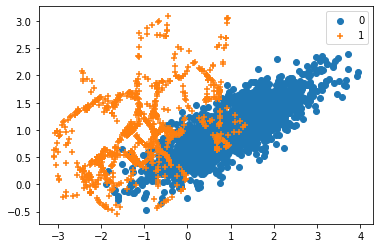

In [33]:
markers = ['o', '+']
for i in range(2):
    xs = X[:, 0][y == i]
    ys = X[:, 1][y == i]
    plt.scatter(xs, ys, marker=markers[i], label=str(i))
plt.legend()
plt.show()

- SMOTE creates a line bridge with the majority class.

## Borderline-SMOTE
- ignore noise points (all the neighbors are majority class) and normal minority class points
- resample only from border points (have both majority and minority classes as neighbors)
- end up giving more attention to extreme points

In [34]:
# Borderline-SMOTE
from imblearn.over_sampling import BorderlineSMOTE
oversample = BorderlineSMOTE(0.1)
X, y = oversample.fit_resample(X_org, y_org)
print(len(y[y==0]), len(y[y==1]))

markers = ['o', '+']
for i in range(2):
    xs = X[:, 0][y == i]
    ys = X[:, 1][y == i]
    plt.scatter(xs, ys, marker=markers[i], label=str(i))
plt.legend()
plt.show()

TypeError: __init__() takes 1 positional argument but 2 were given

- The plot shows that those examples far from the decision boundary are not oversampled. This includes both examples that are easier to classify (those orange points toward the top left of the plot) and those that are overwhelmingly difficult to classify given the strong class overlap (those orange points toward the bottom right of the plot).

# Classification

In [35]:
# resampling first - No !
print("*** Resample First *** \n")
oversample = SMOTE()
X, y = oversample.fit_resample(X_org, y_org)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print_result(X_train, X_test, y_train, y_test)
print("Don't be confused...")

*** Resample First *** 

Shapes:  (13860, 2) (5940, 2) (13860,) (5940,)
Static performance:  
 [[2849  121]
 [ 318 2652]]

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2970
           1       0.96      0.89      0.92      2970

    accuracy                           0.93      5940
   macro avg       0.93      0.93      0.93      5940
weighted avg       0.93      0.93      0.93      5940

AUC score:  0.9774203879422734
Don't be confused...


In [36]:
# resample only on Train dataset ! - this is right !
print("*** Split First *** \n")
X_train, X_test, y_train, y_test = train_test_split(X_org, y_org, test_size=0.3, stratify=y_org)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
print_result(X_train, X_test, y_train, y_test)

*** Split First *** 

Shapes:  (13860, 2) (3000, 2) (13860,) (3000,)
Static performance:  
 [[2845  125]
 [   4   26]]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2970
           1       0.17      0.87      0.29        30

    accuracy                           0.96      3000
   macro avg       0.59      0.91      0.63      3000
weighted avg       0.99      0.96      0.97      3000

AUC score:  0.9414983164983166


In [37]:
# undersampling
print("*** Undersampling *** \n")
X_train, X_test, y_train, y_test = train_test_split(X_org, y_org, test_size=0.3, stratify=y_org)
under = RandomUnderSampler()
X_train, y_train = under.fit_resample(X_train, y_train)
print_result(X_train, X_test, y_train, y_test)

*** Undersampling *** 

Shapes:  (140, 2) (3000, 2) (140,) (3000,)
Static performance:  
 [[2676  294]
 [   2   28]]

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2970
           1       0.09      0.93      0.16        30

    accuracy                           0.90      3000
   macro avg       0.54      0.92      0.55      3000
weighted avg       0.99      0.90      0.94      3000

AUC score:  0.957384960718294


In [38]:
# use both SMOTE and Underssampler
X_train, X_test, y_train, y_test = train_test_split(X_org, y_org, test_size=0.3, stratify=y_org)
over = SMOTE(sampling_strategy=0.1)
X_train, y_train = over.fit_resample(X_train, y_train)
under = RandomUnderSampler(sampling_strategy=0.5)
X_train, y_train = under.fit_resample(X_train, y_train)
print_result(X_train, X_test, y_train, y_test)

Shapes:  (2079, 2) (3000, 2) (2079,) (3000,)
Static performance:  
 [[2917   53]
 [   4   26]]

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2970
           1       0.33      0.87      0.48        30

    accuracy                           0.98      3000
   macro avg       0.66      0.92      0.73      3000
weighted avg       0.99      0.98      0.99      3000

AUC score:  0.9891470258136925


## stratified k-fold cross validation (same class distribution as the original dataset, 1:100)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [ ]:
# Use stratified F-Fold 

from sklearn.model_selection import StratifiedKFold

X, y = X_org.copy(), y_org.copy()
cv = StratifiedKFold(n_splits=5, shuffle=True)
score = []

for train_idx, test_idx in cv.split(X_org, y_org):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
   
    over = SMOTE(sampling_strategy=0.1)
    X_train, y_train = over.fit_resample(X_train, y_train)
    under = RandomUnderSampler(sampling_strategy=0.5)  # ratio
    X_train, y_train = under.fit_resample(X_train, y_train)

    print_result(X_train, X_test, y_train, y_test)


Shapes:  (2376, 2) (2000, 2) (2376,) (2000,)
Static performance:  
 [[1930   50]
 [   5   15]]

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1980
           1       0.23      0.75      0.35        20

    accuracy                           0.97      2000
   macro avg       0.61      0.86      0.67      2000
weighted avg       0.99      0.97      0.98      2000

AUC score:  0.9778914141414141
Shapes:  (2376, 2) (2000, 2) (2376,) (2000,)
Static performance:  
 [[1929   51]
 [   5   15]]

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1980
           1       0.23      0.75      0.35        20

    accuracy                           0.97      2000
   macro avg       0.61      0.86      0.67      2000
weighted avg       0.99      0.97      0.98      2000

AUC score:  0.9320328282828283
Shapes:  (2376, 2) (2000, 2) (2376,) (2000,)


## Different values of the k-nearest neighbors selected in the SMOTE

In [ ]:
X_org, y_org = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	                       n_clusters_per_class=1, weights=[0.99], flip_y=0, 
                           random_state=1)
k_values = [1,2,3,4,5,6,7]

for k in k_values:
    X_train, X_test, y_train, y_test = train_test_split(X_org, y_org, test_size=0.3, stratify=y_org)
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k) # k_neighbors defualt=5
    X_train, y_train = over.fit_resample(X_train, y_train)
    under = RandomUnderSampler(sampling_strategy=0.5)
    X_train, y_train = under.fit_resample(X_train, y_train)
    
    model = RandomForestClassifier(n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    print("AUC score: ", auc(fpr, tpr))


## use Borderline-SMOTE

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

for train_idx, test_idx in cv.split(X_org, y_org):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
   
    over = BorderlineSMOTE(sampling_strategy=0.1)
    X_train, y_train = over.fit_resample(X_train, y_train)
    under = RandomUnderSampler(sampling_strategy=0.5)  # ratio
    X_train, y_train = under.fit_resample(X_train, y_train)
    print_result(X_train, X_test, y_train, y_test)
